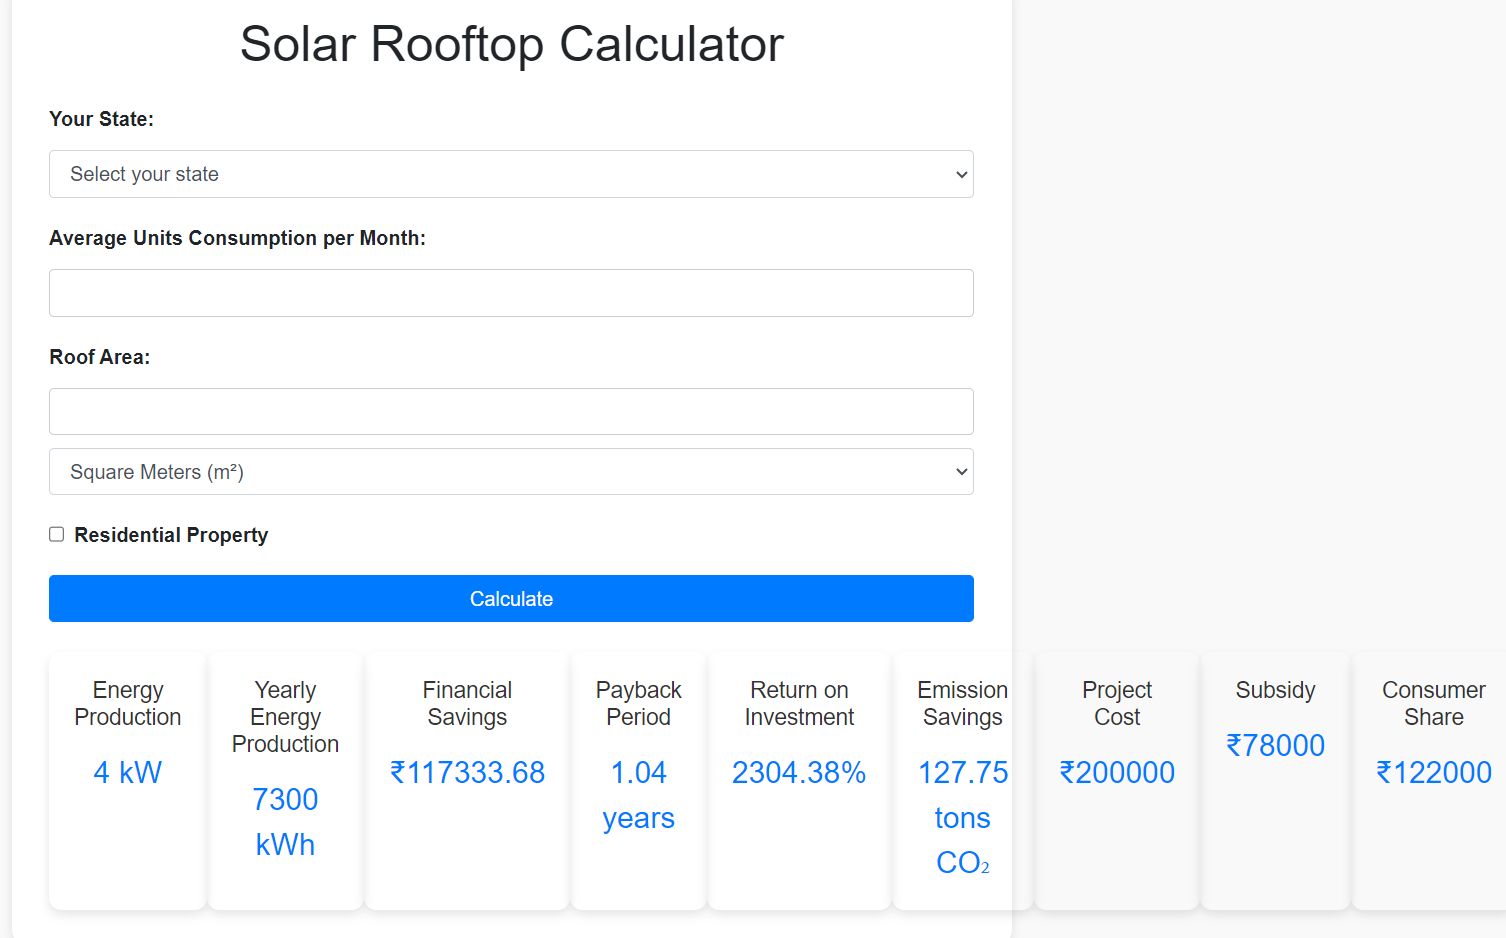

In [1]:
!pip install flask
!pip install pyngrok

In [2]:
!ngrok config add-authtoken 2hguiTCdH1helVkJDvY2c0DywcZ_Vc88G27KizP1sARLP2Gt

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, render_template_string
from pyngrok import ngrok
from threading import Thread

app = Flask(__name__)

RATE_CARD = [
    (100, 4.71, 1.17),
    (300, 10.29, 1.17),
    (500, 14.55, 1.17),
    (float('inf'), 16.64, 1.17)
]

PROJECT_COST_DETAILS = [
    (1, 55000, 30000, 25000),
    (2, 110000, 60000, 50000),
    (3, 155000, 78000, 77000),
    (4, 200000, 78000, 122000),
    (5, 245000, 78000, 167000),
    (6, 290000, 78000, 212000),
    (7, 335000, 78000, 257000),
    (8, 380000, 78000, 302000),
    (9, 425000, 78000, 347000),
    (10, 470000, 78000, 392000),
]

def calculate_electricity_cost(units):
    cost = 0
    remaining_units = units
    for bracket, rate, fixed_cost in RATE_CARD:
        if remaining_units <= 0:
            break
        if remaining_units > bracket:
            cost += bracket * rate
            remaining_units -= bracket
        else:
            cost += remaining_units * rate
            remaining_units = 0
        cost += fixed_cost
    return cost

@app.route('/', methods=['GET', 'POST'])
def index():
    results = None
    error = None
    try:
        if request.method == 'POST':
            state = request.form['state']
            units_consumption = request.form.get('units_consumption')
            roof_area_unit = request.form['roof_area_unit']
            roof_area = float(request.form['roof_area'])
            # required_capacity = float(request.form['required_capacity'])  # Commented out
            # sanction_load = float(request.form['sanction_load'])  # Commented out
            residential = request.form.get('residential')

            if residential:
                sunlight_hours = 5
                cuf = 0.17
                emission_factor = 0.7

                if roof_area_unit == 'ft2':
                    roof_area = roof_area * 0.092903

                panel_capacity_from_area = roof_area * cuf * sunlight_hours

                if units_consumption:
                    units_consumption = float(units_consumption)
                    monthly_kwh_consumption = units_consumption
                    monthly_bill = calculate_electricity_cost(units_consumption)
                else:
                    error = "Please provide the average units consumption."
                    return render_template_string(template, results=results, error=error)

                panel_capacity_from_bill = monthly_kwh_consumption / (sunlight_hours * 30)
                recommendation = min(panel_capacity_from_area, panel_capacity_from_bill)
                recommendation = round(recommendation)

                yearly_energy = recommendation * 365 * sunlight_hours
                financial_savings = calculate_electricity_cost(yearly_energy)

                project_cost_details = next((details for cap, *details in PROJECT_COST_DETAILS if cap == recommendation), None)
                if project_cost_details:
                    project_cost, subsidy, consumer_share = project_cost_details
                else:
                    project_cost = subsidy = consumer_share = 0

                payback_period = consumer_share / financial_savings if financial_savings != 0 else float('inf')
                roi = (financial_savings * 25 - consumer_share) / consumer_share * 100 if consumer_share != 0 else 0
                emission_savings = yearly_energy / 1000 * emission_factor * 25

                results = {
                    'energy': round(recommendation, 2),
                    'yearly_energy': round(yearly_energy, 2),
                    'financial_savings': round(financial_savings, 2),
                    'payback_period': round(payback_period, 2),
                    'roi': round(roi, 2),
                    'emission_savings': round(emission_savings, 2),
                    'project_cost': project_cost,
                    'subsidy': subsidy,
                    'consumer_share': consumer_share
                }
            else:
                error = "Solar calculations are only for residential properties."

        return render_template_string(template, results=results, error=error)
    except Exception as e:
        return str(e)

template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Solar Rooftop Calculator</title>
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f9f9f9;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
        }
        .container {
            background: #fff;
            padding: 30px;
            border-radius: 15px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            max-width: 800px;
            width: 100%;
        }
        .form-group {
            margin-bottom: 20px;
        }
        label {
            font-weight: bold;
        }
        input[type="number"],
        select {
            width: 100%;
            padding: 10px;
            margin-top: 5px;
            margin-bottom: 10px;
            border: 1px solid #ccc;
            border-radius: 4px;
            transition: border-color 0.3s;
        }
        input[type="number"]:focus,
        select:focus {
            border-color: #007bff;
        }
        button {
            width: 100%;
            padding: 12px;
            background-color: #007bff;
            color: #fff;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            font-size: 16px;
            transition: background-color 0.3s;
        }
        button:hover {
            background-color: #0056b3;
        }
        .result-container {
            display: flex;
            justify-content: space-around;
            margin-top: 20px;
        }
        .result-card {
            border-radius: 10px;
            padding: 20px;
            text-align: center;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            width: 45%;
        }
        .result-card h5 {
            margin-bottom: 15px;
            font-size: 18px;
            color: #333;
        }
        .result-card span {
            display: block;
            font-size: 24px;
            color: #007bff;
        }
        .result-card .unit {
            font-size: 16px;
            color: #555;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1 class="text-center mb-4">Solar Rooftop Calculator</h1>
        <form action="/" method="post" id="solarForm">
            <div class="form-group">
                <label for="state">Your State:</label>
                <select id="state" name="state" class="form-control" required>
                    <option value="" disabled selected>Select your state</option>
                    <option value="Andhra Pradesh">Andhra Pradesh</option>
                    <option value="Arunachal Pradesh">Arunachal Pradesh</option>
                    <option value="Assam">Assam</option>
                    <option value="Bihar">Bihar</option>
                    <option value="Chhattisgarh">Chhattisgarh</option>
                    <option value="Goa">Goa</option>
                    <option value="Gujarat">Gujarat</option>
                    <option value="Haryana">Haryana</option>
                    <option value="Himachal Pradesh">Himachal Pradesh</option>
                    <option value="Jharkhand">Jharkhand</option>
                    <option value="Karnataka">Karnataka</option>
                    <option value="Kerala">Kerala</option>
                    <option value="Madhya Pradesh">Madhya Pradesh</option>
                    <option value="Maharashtra">Maharashtra</option>
                    <option value="Manipur">Manipur</option>
                    <option value="Meghalaya">Meghalaya</option>
                    <option value="Mizoram">Mizoram</option>
                    <option value="Nagaland">Nagaland</option>
                    <option value="Odisha">Odisha</option>
                    <option value="Punjab">Punjab</option>
                    <option value="Rajasthan">Rajasthan</option>
                    <option value="Sikkim">Sikkim</option>
                    <option value="Tamil Nadu">Tamil Nadu</option>
                    <option value="Telangana">Telangana</option>
                    <option value="Tripura">Tripura</option>
                    <option value="Uttar Pradesh">Uttar Pradesh</option>
                    <option value="Uttarakhand">Uttarakhand</option>
                    <option value="West Bengal">West Bengal</option>
                    <option value="Delhi">Delhi</option>
                    <option value="Jammu and Kashmir">Jammu and Kashmir</option>
                    <option value="Ladakh">Ladakh</option>
                </select>
            </div>
            <div class="form-group">
                <label for="units_consumption">Average Units Consumption per Month:</label>
                <input type="number" id="units_consumption" name="units_consumption" class="form-control" required>
            </div>
            <div class="form-group">
                <label for="roof_area">Roof Area:</label>
                <input type="number" id="roof_area" name="roof_area" class="form-control" required>
                <select id="roof_area_unit" name="roof_area_unit" class="form-control" required>
                    <option value="m2">Square Meters (m²)</option>
                    <option value="ft2">Square Feet (ft²)</option>
                </select>
            </div>
            <div class="form-group">
                <div class="form-check">
                    <input class="form-check-input" type="checkbox" id="residential" name="residential">
                    <label class="form-check-label" for="residential">Residential Property</label>
                </div>
            </div>
            <button type="submit" class="btn btn-primary">Calculate</button>
        </form>
        {% if error %}
            <div class="alert alert-danger mt-3">{{ error }}</div>
        {% endif %}
        {% if results %}
            <div class="result-container mt-4">
                <div class="result-card">
                    <h5>Energy Production</h5>
                    <span>{{ results.energy }} kW</span>
                </div>
                <div class="result-card">
                    <h5>Yearly Energy Production</h5>
                    <span>{{ results.yearly_energy }} kWh</span>
                </div>
                <div class="result-card">
                    <h5>Financial Savings</h5>
                    <span>₹{{ results.financial_savings }}</span>
                </div>
                <div class="result-card">
                    <h5>Payback Period</h5>
                    <span>{{ results.payback_period }} years</span>
                </div>
                <div class="result-card">
                    <h5>Return on Investment</h5>
                    <span>{{ results.roi }}%</span>
                </div>
                <div class="result-card">
                    <h5>Emission Savings</h5>
                    <span>{{ results.emission_savings }} tons CO₂</span>
                </div>
                <div class="result-card">
                    <h5>Project Cost</h5>
                    <span>₹{{ results.project_cost }}</span>
                </div>
                <div class="result-card">
                    <h5>Subsidy</h5>
                    <span>₹{{ results.subsidy }}</span>
                </div>
                <div class="result-card">
                    <h5>Consumer Share</h5>
                    <span>₹{{ results.consumer_share }}</span>
                </div>
            </div>
        {% endif %}
    </div>
</body>
</html>
'''

def run():
    app.run(port=5000)

thread = Thread(target=run)
thread.start()

public_url = ngrok.connect(5000).public_url
print(f" * ngrok tunnel available at {public_url} *")

# Keep the Flask server running
thread.join()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * ngrok tunnel available at https://d5f2-35-196-39-21.ngrok-free.app *


INFO:werkzeug:127.0.0.1 - - [18/Jun/2024 15:16:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jun/2024 15:16:36] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jun/2024 15:16:48] "POST / HTTP/1.1" 200 -
